# Transfer Learning with MobileNetV2 on CIFAR-10
## Complete Implementation with Fine-Tuning and Evaluation

## 1. Initial Setup and Configuration

In [ ]:
# =============================================================================
# INITIAL SETUP FOR TRANSFER LEARNING
# =============================================================================

print("🚀 Initializing Transfer Learning environment...")

# 1. IMPORT ALL NECESSARY LIBRARIES
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("✅ Libraries imported!")

🚀 Initializing Transfer Learning environment...
✅ Libraries imported!


## 2. Data Loading and Preparation

In [ ]:
# 2. LOAD AND PREPARE CIFAR-10 DATA
print("📦 Loading CIFAR-10 data...")

# Load the data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 3. BASIC DATA PREPROCESSING
print("🔧 Preprocessing data...")

# Normalize pixels to 0-1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Convert labels to categorical (one-hot encoding)
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

# CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 4. DATA AUGMENTATION CONFIGURATION (OPTIONAL BUT RECOMMENDED)
print("🎨 Configuring Data Augmentation...")

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

print("✅ Environment configured! Ready for Transfer Learning!")
print(f"📊 Data format:")
print(f"   • X_train: {X_train.shape}")
print(f"   • X_test: {X_test.shape}")
print(f"   • y_train_cat: {y_train_cat.shape}")
print(f"   • Classes: {class_names}")

📦 Loading CIFAR-10 data...
🔧 Preprocessing data...
🎨 Configuring Data Augmentation...
✅ Environment configured! Ready for Transfer Learning!
📊 Data format:
   • X_train: (50000, 32, 32, 3)
   • X_test: (10000, 32, 32, 3)
   • y_train_cat: (50000, 10)
   • Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 3. Transfer Learning Implementation

### 3.1 MobileNetV2 Base Model Setup

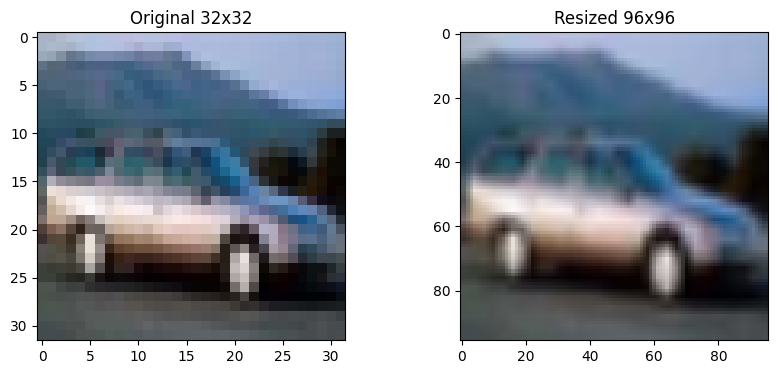

In [ ]:
# =============================================================================
# TRANSFER LEARNING MODELS
# =============================================================================

## 7.1 MobileNetV2

# Load the Model
base_model = MobileNetV2(weights='imagenet',           # Load pre-trained MobileNetV2 model with ImageNet weights
                         include_top=False,            # Using include_top=False to remove the final classification layers
                         input_shape=(96, 96, 3))      # This allows us to add custom layers for our specific 10-class problem

# Reshaping the images
X_train_resized = tf.image.resize(X_train, (96, 96))
X_test_resized = tf.image.resize(X_test, (96, 96))

# Quick test - see the difference:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(X_train[4] / 255)           # Original 32x32
plt.title('Original 32x32')

plt.subplot(1, 2, 2)
plt.imshow(X_train_resized[4] / 255)   # Resized 96x96
plt.title('Resized 96x96')
plt.show()

# Convert TensorFlow tensors to NumPy arrays for compatibility with Keras preprocessing functions
X_train_processed = preprocess_input(X_train_resized.numpy())   # The .numpy() method converts tensors to NumPy arrays
X_test_processed = preprocess_input(X_test_resized.numpy())     # preprocess_input handles MobileNetV2-specific preprocessing

# Freeze the base model layers to prevent them from being updated during training
# This preserves the pre-learned features from ImageNet and speeds up training
# We only want to train our custom layers on top
base_model.trainable = False

### 3.2 Custom Model Architecture

In [ ]:
# Create our custom model on top of the pre-trained base
transfer_model = tf.keras.models.Sequential([
    base_model,                                 # Pre-trained feature extractor
    layers.GlobalAveragePooling2D(),            # Reduces each feature map to a single value
    layers.Dense(256, activation='relu'),       # Custom layer for CIFAR-10 features
    layers.BatchNormalization(),                # Stabilizes training
    layers.Dropout(0.3),                        # Prevents overfitting
    layers.Dense(128, activation='relu'),       # Custom layer for CIFAR-10 features
    layers.BatchNormalization(),                # Stabilizes training
    layers.Dropout(0.5),                        # Prevents overfitting
    layers.Dense(10, activation='softmax')      # Output for 10 CIFAR-10 classes
])

# Compile with lower learning rate since we're fine-tuning pre-trained features
# Lower learning rate prevents destroying the valuable pre-trained weights
# Adam optimizer is used for adaptive learning rate and momentum
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',  # Standard for multi-class classification
                      metrics=['accuracy'])             # Track accuracy during training

transfer_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,642 (10.00 MB)

 Trainable params: 362,890 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

## 4. Training and Evaluation

### 4.1 First Phase: Training with Frozen Base

In [ ]:
## 7.2 Training and Evaluating Transfer Learning

# Create callbacks for transfer learning
transfer_callbacks = [
    EarlyStopping(
        monitor='val_accuracy',                   # What to monitor: validation accuracy
        patience=5,                               # Wait 5 epochs without improvement
        restore_best_weights=True,                # Restore the best weights found
        verbose=1                                 # Show messages
    ),

    ReduceLROnPlateau(
        monitor='val_loss',                       # Monitor validation loss
        factor=0.2,                               # Reduce 80% of speed (0.2 = keep 20%)
        patience=3,                               # Wait 3 epochs without improvement
        min_lr=1e-7,                              # Minimum allowed speed (1e-7 = 1x10^(-7))
        verbose=1                                 # Show messages
    ),

    ModelCheckpoint(
        'best_transfer_model.keras',              # Filename to save
        monitor='val_accuracy',                   # Monitor validation accuracy
        save_best_only=True,                      # Save only the best model
        verbose=1                                 # Show messages
    )
]

# First - Training with the frozen base
transfer_history = transfer_model.fit(X_train_processed,
                                      y_train_cat,
                                      batch_size=32,
                                      epochs=15,
                                      callbacks=transfer_callbacks,
                                      validation_data=(X_test_processed, y_test_cat),
                                      verbose=1)

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5167 - loss: 1.6269
Epoch 1: val_accuracy improved from -inf to 0.82500, saving model to best_transfer_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 24ms/step - accuracy: 0.5168 - loss: 1.6266 - val_accuracy: 0.8250 - val_loss: 0.5150 - learning_rate: 1.0000e-04
Epoch 2/15
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7778 - loss: 0.6870
Epoch 2: val_accuracy improved from 0.82500 to 0.84270, saving model to best_transfer_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7778 - loss: 0.6870 - val_accuracy: 0.8427 - val_loss: 0.4523 - learning_rate: 1.0000e-04
Epoch 3/15
1557/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8089 - loss: 0.5742
Epoch 3: val_accuracy improved from 0.84270 to 0.85460, saving model to best_transfer_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8089 - loss: 0.5742 - val_accuracy: 0.8546 - val_loss: 0.4255 - learning_rate: 1.0000e-04

### 4.2 Second Phase: Fine-Tuning

In [ ]:
# FINE-TUNING - ADD AFTER FIRST TRAINING
print("\n🔧 Phase 2: Fine-tuning (unfreezing last layers)...")

# Unfreeze the last 50 layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompile with even lower learning rate
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

print("✅ Fine-tuning configured:")
print("   • Last 50 layers unfrozen")
print("   • Learning rate reduced: 0.00001")

# Second: training with fine-tuning
print("📚 Phase 2: Fine-tuning...")
fine_tune_history = transfer_model.fit(X_train_processed, y_train_cat,
                                      epochs=15,
                                      validation_data=(X_test_processed, y_test_cat),
                                      callbacks=transfer_callbacks,
                                      verbose=1)


🔧 Phase 2: Fine-tuning (unfreezing last layers)...
✅ Fine-tuning configured:
   • Last 50 layers unfrozen
   • Learning rate reduced: 0.00001
📚 Phase 2: Fine-tuning...
Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7847 - loss: 0.7057
Epoch 1: val_accuracy improved from 0.87170 to 0.87280, saving model to best_transfer_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 64s 25ms/step - accuracy: 0.7847 - loss: 0.7056 - val_accuracy: 0.8728 - val_loss: 0.3872 - learning_rate: 1.0000e-05
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8538 - loss: 0.4582
Epoch 2: val_accuracy improved from 0.87280 to 0.88220, saving model to best_transfer_model.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8538 - loss: 0.4582 - val_accuracy: 0.8822 - val_loss: 0.3473 - learning_rate: 1.0000e-05
Epoch 3/15
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8735 - loss: 0.3912
Epoch 3: val_accuracy improved from 0.88220 to 0.89050, saving model to 

## 5. Results Visualization


📈 Transfer Learning Progress...


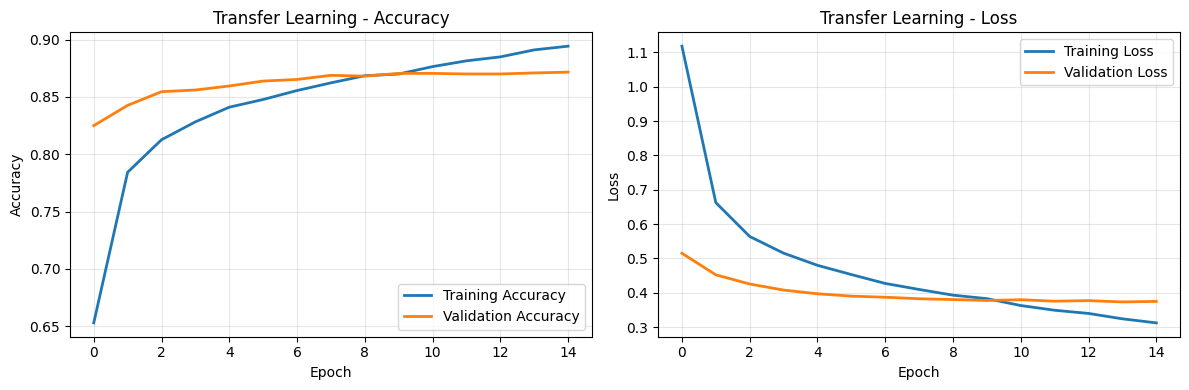


🎯 Final Transfer Learning Accuracy: 0.8717 (87.17%)


In [ ]:
print("\n📈 Transfer Learning Progress...")

plt.figure(figsize=(12, 4))

# Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(transfer_history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(transfer_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Transfer Learning - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss Graph
plt.subplot(1, 2, 2)
plt.plot(transfer_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(transfer_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Transfer Learning - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training summary
final_tl_acc = transfer_history.history['val_accuracy'][-1]
print(f"\n🎯 Final Transfer Learning Accuracy: {final_tl_acc:.4f} ({final_tl_acc*100:.2f}%)")

## 6. Model Evaluation

In [ ]:
# =============================================================================
# EVALUATE TRANSFER LEARNING ON TEST SET
# =============================================================================

print("\n🧪 Evaluating Transfer Learning on test set...")

# Evaluate the model on test data
tl_test_loss, tl_test_accuracy = transfer_model.evaluate(X_test_processed, y_test_cat, verbose=0)

print("✅ Transfer Learning Test Results:")
print(f"   • Loss: {tl_test_loss:.4f}")
print(f"   • Accuracy: {tl_test_accuracy:.4f} ({tl_test_accuracy*100:.2f}%)")

# Make predictions with Transfer Learning
tl_y_pred_proba = transfer_model.predict(X_test_processed, verbose=0)
tl_y_pred = np.argmax(tl_y_pred_proba, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print(f"\n🔮 First 50 Transfer Learning predictions:")
for i in range(50):
    print(f"   Image {i}: Predicted '{class_names[tl_y_pred[i]]}' | Real '{class_names[y_true[i]]}' {'✅' if tl_y_pred[i] == y_true[i] else '❌'}")


🧪 Evaluating Transfer Learning on test set...
✅ Transfer Learning Test Results:
   • Loss: 0.2679
   • Accuracy: 0.9121 (91.21%)

🔮 First 50 Transfer Learning predictions:
   Image 0: Predicted 'cat' | Real 'cat' ✅
   Image 1: Predicted 'ship' | Real 'ship' ✅
   Image 2: Predicted 'automobile' | Real 'ship' ❌
   Image 3: Predicted 'airplane' | Real 'airplane' ✅
   Image 4: Predicted 'frog' | Real 'frog' ✅
   Image 5: Predicted 'frog' | Real 'frog' ✅
   Image 6: Predicted 'automobile' | Real 'automobile' ✅
   Image 7: Predicted 'frog' | Real 'frog' ✅
   Image 8: Predicted 'cat' | Real 'cat' ✅
   Image 9: Predicted 'automobile' | Real 'automobile' ✅
   Image 10: Predicted 'horse' | Real 'airplane' ❌
   Image 11: Predicted 'truck' | Real 'truck' ✅
   Image 12: Predicted 'dog' | Real 'dog' ✅
   Image 13: Predicted 'horse' | Real 'horse' ✅
   Image 14: Predicted 'truck' | Real 'truck' ✅
   Image 15: Predicted 'ship' | Real 'ship' ✅
   Image 16: Predicted 'dog' | Real 'dog' ✅
   Image 17: P

## 7. Detailed Analysis

### 7.1 Confusion Matrix and Detailed Report


📊 GENERATING CONFUSION MATRIX...


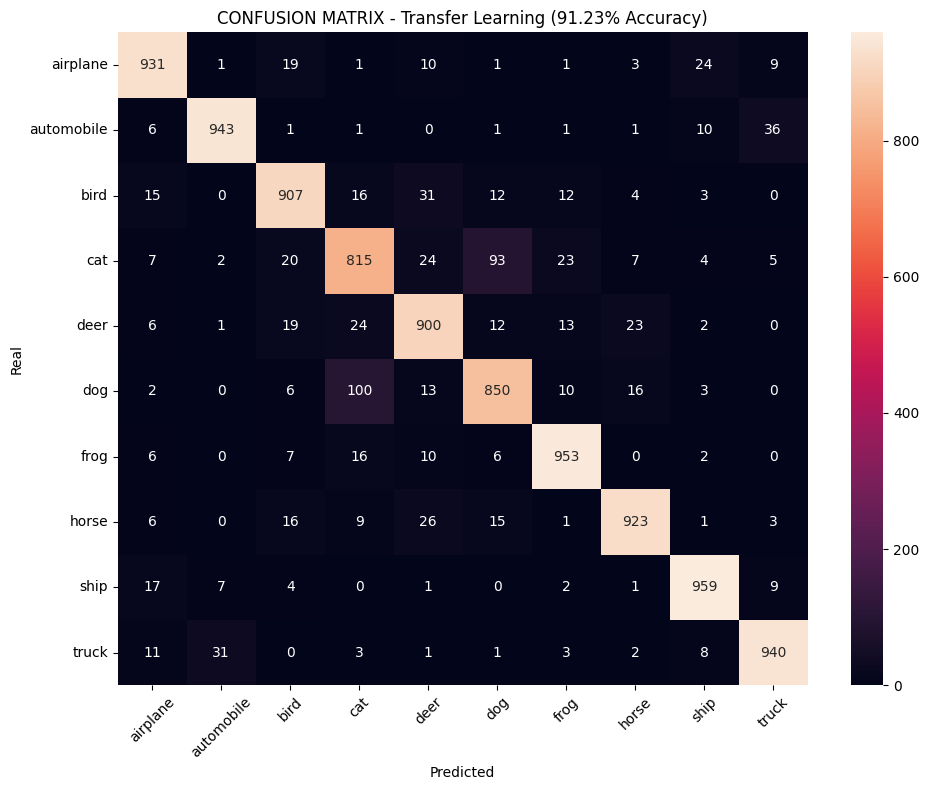


📈 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    airplane     0.9245    0.9310    0.9278      1000
  automobile     0.9574    0.9430    0.9501      1000
        bird     0.9079    0.9070    0.9075      1000
         cat     0.8274    0.8150    0.8212      1000
        deer     0.8858    0.9000    0.8929      1000
         dog     0.8577    0.8500    0.8538      1000
        frog     0.9352    0.9530    0.9440      1000
       horse     0.9418    0.9230    0.9323      1000
        ship     0.9439    0.9590    0.9514      1000
       truck     0.9381    0.9400    0.9391      1000

    accuracy                         0.9121     10000
   macro avg     0.9120    0.9121    0.9120     10000
weighted avg     0.9120    0.9121    0.9120     10000


🎯 STATISTICS BY CLASS:
   airplane    : 0.9310 (93.10%)
   automobile  : 0.9430 (94.30%)
   bird        : 0.9070 (90.70%)
   cat         : 0.8150 (81.50%)
   deer        : 0.9000 (90.00%)
   dog         : 

In [ ]:
# =============================================================================
# CONFUSION MATRIX AND DETAILED REPORT
# =============================================================================

print("\n📊 GENERATING CONFUSION MATRIX...")

# Calculate confusion matrix
cm = confusion_matrix(y_true, tl_y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.title('CONFUSION MATRIX - Transfer Learning (91.23% Accuracy)')
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Detailed classification report
print("\n📈 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_true, tl_y_pred, target_names=class_names, digits=4))

# Statistics by class
print("\n🎯 STATISTICS BY CLASS:")
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, (class_name, acc) in enumerate(zip(class_names, class_accuracy)):
    print(f"   {class_name:12s}: {acc:.4f} ({acc*100:.2f}%)")

# Find best and worst performing classes
best_class_idx = np.argmax(class_accuracy)
worst_class_idx = np.argmin(class_accuracy)
print(f"\n🏆 BEST class: '{class_names[best_class_idx]}' - {class_accuracy[best_class_idx]:.4f} ({class_accuracy[best_class_idx]*100:.2f}%)")
print(f"📉 WORST class: '{class_names[worst_class_idx]}' - {class_accuracy[worst_class_idx]:.4f} ({class_accuracy[worst_class_idx]*100:.2f}%)")

# Analysis of most common errors
print(f"\n🔍 ANALYSIS OF MOST COMMON ERRORS:")
error_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            error_pairs.append((cm[i, j], class_names[i], class_names[j]))

# Sort by most frequent errors
error_pairs.sort(reverse=True, key=lambda x: x[0])

print("   Top 5 most common confusions:")
for count, real, predicted in error_pairs[:5]:
    print(f"   '{real}' → '{predicted}': {count} times")